In [ ]:
from model import *
from utils import *
from training import *

import importlib
import imports
importlib.reload(imports)

device = 'mps'
model_name = 'batchnorm'

# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/ncmapps_ds02.csv


In [3]:
df = pd.read_csv(filename)
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [4]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [5]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [6]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


In [ ]:
# dataset parameters
TRAIN_UNITS = [2, 5, 10, 16, 18, 20]
TEST_UNITS = [11, 14, 15]

DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18, 
    'out_channels': 1,
    'window': 50, 
    'n_ch': 10, 
    'n_k': 10, 
    'n_hidden': 50, 
    'n_layers': 3,
    'dropout': 0.,
    'padding': 'same',
    'use_batchnorm': True,
    # training parameters
    'batch_size': 512,  
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 30
    }


DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 403236	validation_size: 100809	test_size: 115274


In [10]:
def run_single(seed, params=DEFAULT_PARAMS):
    seed_everything(seed)

    model = CNN(
        in_channels=params['in_channels'],
        out_channels=params['out_channels'], 
        n_ch=params['n_ch'],
        n_k=params['n_k'],
        n_hidden=params['n_hidden'],
        n_layers=params['n_layers'],
        dropout=params['dropout'],
        padding=params['padding'],
        use_batchnorm=params['use_batchnorm']
    ).to(device)  # Move model to device immediately after creation

    print(model)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['base_lr'],
        weight_decay=params['weight_decay'],
    )

    criterion = nn.MSELoss()
    trainer = Trainer(
        model,
        optimizer,
        criterion=criterion,
        n_epochs=params['max_epochs'],
        seed=seed,
        device=device  # Pass device to trainer
    )

    trainer.fit(LOADERS)
    df_eval, df_eval_out = trainer.eval_rul_prediction(LOADERS[1])
    df_test, df_test_out = trainer.eval_rul_prediction(LOADERS[2])
    return df_eval, df_eval_out, df_test, df_test_out, trainer.losses4aggregation

## TRAINING ON 5 SEEDS

In [11]:
SEED = 42
seed_everything(SEED)
device = 'mps'
N_RUNS = 5

df_list = []  
all_df_test = []
all_train_losses = []
all_eval_losses = []
all_test_losses = []

for seed in range(SEED, SEED+N_RUNS):
    print("--------------------- BEGGINING NEW SEED:", seed, "----------------")
    df_eval, df_eval_out, df_test, df_test_out, losses4aggregation = run_single(seed)
    all_train_losses.append(losses4aggregation['train'])
    all_eval_losses.append(losses4aggregation['eval'])
    all_test_losses.append(losses4aggregation['test'])
    all_df_test.append(df_test)
    df_list.append(df_test_out)  

df_all = pd.concat(df_list, ignore_index=True)  
all_train_losses = np.array(all_train_losses)
all_eval_losses = np.array(all_eval_losses)
all_test_losses = np.array(all_test_losses)

--------------------- BEGGINING NEW SEED: 42 ----------------
CNN(
  (conv_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (7): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (bn_fc): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Training model for 30 epochs...
[Epoch 1] train_loss = 264.47134, eval_lo

KeyboardInterrupt: 

# PLOTTING RESULTS

In [39]:
plot_test_rul_predictions(all_df_test, model_name='baseline', save=True, show=False)


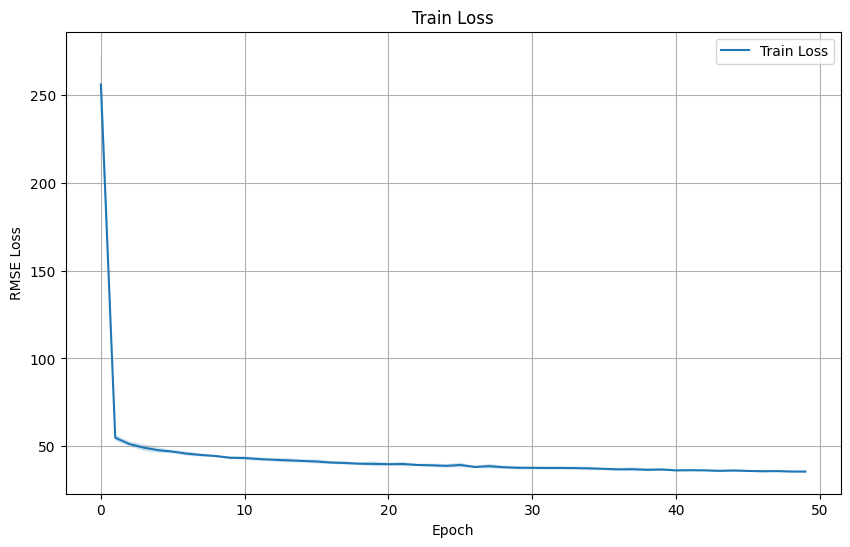

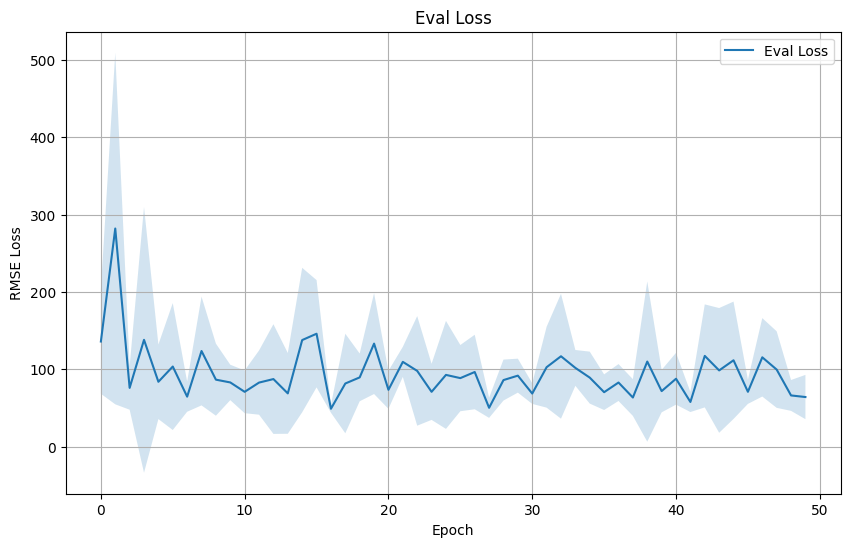

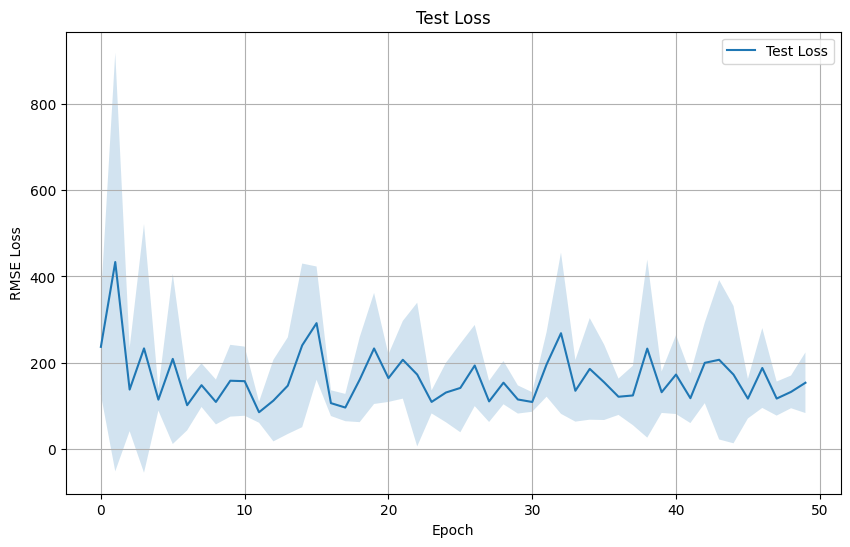

In [31]:

# Plot the aggregated losses
plot_aggregated_losses(all_train_losses, all_eval_losses, all_test_losses, model_name='baseline', save=True, show=True)


In [ ]:
model_name = 'batchnorm'
df_all.to_csv(f'test_scores/{model_name}_df_all.csv', index=False)
df_all.head()

,score,rmse,seed
0,2.463061,8.036067,42
1,1.883596,5.741760,43
2,2.296901,7.453077,44
3,2.039855,6.471716,45
4,2.073622,6.608436,46
